In [1]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import struct
import torch.utils.data as Data
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

myFont = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 17,
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_images(file_name):
    binfile = open(file_name, 'rb') 
    buffers = binfile.read()
    magic,num,rows,cols = struct.unpack_from('>IIII',buffers, 0)
    bits = num * rows * cols
    images = struct.unpack_from('>' + str(bits) + 'B', buffers, struct.calcsize('>IIII'))
    binfile.close()
    images = np.reshape(images, [num, rows * cols])
    return images

images = load_images('/content/drive/MyDrive/train-images-idx3-ubyte')

In [4]:
images.shape, images.shape[0], np.expand_dims(np.reshape(images[59999], [28,28]), axis=0).shape

((60000, 784), 60000, (1, 28, 28))

In [5]:
pretraining_imgs = []
pretraining_label = []
for i in range(images.shape[0]):
    original_img = np.reshape(images[i] / 255.0, [28,28])
    degree = random.randint(0,3)
    rotated_img = np.rot90(original_img, degree)
    pretraining_imgs.append(np.expand_dims(rotated_img, axis=0))
    one_hot = np.zeros(4)
    one_hot[degree] = 1
    pretraining_label.append(one_hot)

pretraining_imgs = torch.Tensor(np.array(pretraining_imgs))
pretraining_label = torch.Tensor(np.array(pretraining_label))

In [6]:
pretraining_dataset = Data.TensorDataset(pretraining_imgs, pretraining_label)
pretraining_data_loader = Data.DataLoader(
    dataset = pretraining_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 2,
)

In [7]:
class Pre(nn.Module):
    def __init__(self):
        super(Pre, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,6,3,1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,3,1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(400,128),
            nn.ReLU(),
        )
        self.fc2 = nn.Linear(128,4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        conv_out = x.view(x.size(0),-1)
        x = self.fc1(conv_out)
        x = self.fc2(x)
        return x, conv_out

pre = Pre()
summary(pre, (1,28,28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
              ReLU-3            [-1, 6, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]             880
         MaxPool2d-5             [-1, 16, 5, 5]               0
              ReLU-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 128]          51,328
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 4]             516
Total params: 52,784
Trainable params: 52,784
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.20
Estimated Total Size (MB): 0.27
---------------------------------------------

In [8]:
'''
Pre-trainning: LeNet
'''
epochs = 30
pretraining_loss = []

for epoch in range(epochs):
    for inputs, labels in pretraining_data_loader:
        optimizer.zero_grad()
        outputs, _ = pre(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('epoch ',epoch,':',' loss = ',loss.item(),sep='')
    pretraining_loss.append(loss.item())

epoch 0: loss = 0.04812489449977875
epoch 1: loss = 0.14297136664390564
epoch 2: loss = 0.007168005220592022
epoch 3: loss = 0.025927817448973656
epoch 4: loss = 0.0024561267346143723
epoch 5: loss = 0.4150107502937317
epoch 6: loss = 0.11556264758110046
epoch 7: loss = 0.006457117386162281
epoch 8: loss = 0.22559979557991028
epoch 9: loss = 0.038852740079164505
epoch 10: loss = 0.0484805591404438
epoch 11: loss = 0.17714528739452362
epoch 12: loss = 0.006038700230419636
epoch 13: loss = 0.026159098371863365
epoch 14: loss = 0.2257615029811859
epoch 15: loss = 0.0062231747433543205
epoch 16: loss = 0.009181531146168709
epoch 17: loss = 0.283892422914505
epoch 18: loss = 0.05950259789824486
epoch 19: loss = 0.031105605885386467
epoch 20: loss = 0.0987643226981163
epoch 21: loss = 0.00021491473307833076
epoch 22: loss = 0.001941510010510683
epoch 23: loss = 0.000191306637134403
epoch 24: loss = 0.00018552521942183375
epoch 25: loss = 6.52311573503539e-05
epoch 26: loss = 0.00102167972363

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


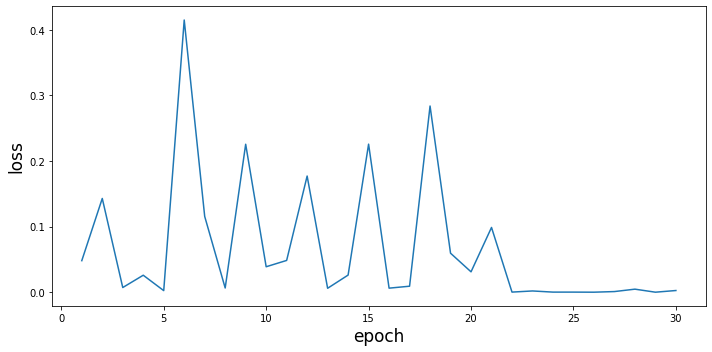

In [9]:
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs+1), pretraining_loss)
plt.xlabel('epoch', myFont)
plt.ylabel('loss', myFont)
plt.tight_layout()
plt.show()

In [18]:
np.save('/content/drive/MyDrive/Rotate_losslist', pretraining_loss)

In [10]:
transform = transforms.ToTensor()

data_train = datasets.MNIST(root = "./data/",
                            transform = transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(400,120),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        _, x = pre(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()
model = net.to('cpu')
# summary(model, (1,28,28))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre.parameters(), lr=0.01)

In [16]:
'''
Trainning
'''
epochs = 50
# training_loss = []
 
for epoch in range(epochs):
    for _, data in enumerate(data_loader_train):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('epoch ',epoch,':',' loss = ',loss.item(),sep='')
    # training_loss.append(loss.item())


epoch 0: loss = 1.5270565748214722
epoch 1: loss = 1.4092721939086914
epoch 2: loss = 1.3595867156982422
epoch 3: loss = 1.010462760925293
epoch 4: loss = 0.8910853862762451
epoch 5: loss = 0.629279613494873
epoch 6: loss = 0.9521475434303284
epoch 7: loss = 0.8702934980392456
epoch 8: loss = 0.8491342663764954
epoch 9: loss = 1.0553112030029297
epoch 10: loss = 1.0252010822296143
epoch 11: loss = 0.8239184617996216
epoch 12: loss = 0.8199509382247925
epoch 13: loss = 1.135812759399414
epoch 14: loss = 1.2677980661392212
epoch 15: loss = 0.93701171875
epoch 16: loss = 1.263514518737793
epoch 17: loss = 0.9342330098152161
epoch 18: loss = 0.5994344353675842
epoch 19: loss = 0.7859915494918823
epoch 20: loss = 1.1452782154083252
epoch 21: loss = 0.7117476463317871
epoch 22: loss = 1.069559931755066
epoch 23: loss = 0.9659514427185059
epoch 24: loss = 0.8757608532905579
epoch 25: loss = 0.7611624598503113
epoch 26: loss = 1.0265581607818604
epoch 27: loss = 0.7722664475440979
epoch 28: lo

In [17]:
total = 0
correct = 0
for inputs, labels in data_loader_test:
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 75.52 %
